In [1]:
###Python Packages###

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.colors import LogNorm
import math as mth
import timeit
from scipy import optimize
from scipy import *
import scipy
from scipy import stats
import tables
import h5py
import ODE_utils as odeu
#import matplotlib.animation as animation
#!jt -t onedork -cellw 90%

### This code displays results for every function

This is a comprehensive code that is less focused but possibly the most useful code to get an over all picture of the results


In [2]:
uscal=50
vscal=5
extraterms=True

uscal and vscal reduce arrays by their value in order to prevent memory overflow. Use when h5 files are very large (i.e. >2gB)

In [3]:
rnputil=np.load('rnputil.npy')
urange=np.load('urange.npy')[::uscal]
vrange=np.load('vrange.npy')[::vscal]

In [4]:
with h5py.File('rnp.h5','r') as f:
    r_group_key = list(f.keys())[0]
    rnpi=f[r_group_key]
    rnp = np.asarray(rnpi[::uscal,::vscal],dtype=np.float_)    
with h5py.File('signp.h5','r') as f:
    sig_group_key = list(f.keys())[0]
    signpi=f[sig_group_key]
    signp = np.asarray(signpi[::uscal,::vscal],dtype=np.float_)
with h5py.File('phinp.h5','r') as f:
    phi_group_key = list(f.keys())[0]
    phinpi=f[phi_group_key]
    phinp = np.asarray(phinpi[::uscal,::vscal],dtype=np.float_)
with h5py.File('massnp.h5','r') as f:
    mass_group_key = list(f.keys())[0]
    massnpi=f[mass_group_key]
    massnp = np.asarray(massnpi[::uscal,::vscal])
    
    
if extraterms==True:
    with h5py.File('drnpu.h5','r') as f:
        dru_group_key = list(f.keys())[0]
        drnpui=f[dru_group_key]
        drnpu = np.asarray(drnpui[::uscal,::vscal],dtype=np.float_)
    with h5py.File('drnpv.h5','r') as f:
        drv_group_key = list(f.keys())[0]
        drnpvi=f[drv_group_key]
        drnpv = np.asarray(drnpvi[::uscal,::vscal],dtype=np.float_)
        
    with h5py.File('dsignpu.h5','r') as f:
        dsigu_group_key = list(f.keys())[0]
        dsignpui=f[dsigu_group_key]
        dsignpu = np.asarray(dsignpui[::uscal,::vscal],dtype=np.float_)
    with h5py.File('dsignpv.h5','r') as f:
        dsigv_group_key = list(f.keys())[0]
        dsignpvi=f[dsigv_group_key]
        dsignpv = np.asarray(dsignpvi[::uscal,::vscal],dtype=np.float_)
        
    with h5py.File('dphinpu.h5','r') as f:
        dphiu_group_key = list(f.keys())[0]
        dphinpui=f[dphiu_group_key]
        dphinpu = np.asarray(dphinpui[::uscal,::vscal],dtype=np.float_)
    with h5py.File('dphinpv.h5','r') as f:
        dphiv_group_key = list(f.keys())[0]
        dphinpvi=f[dphiv_group_key]
        dphinpv = np.asarray(dphinpvi[::uscal,::vscal],dtype=np.float_)
    
    

print(str(rnp.nbytes)+" bytes")

print(rnp)

switchax=rnputil[9]
print(switchax)
if switchax==True:
    rnp=np.swapaxes(rnp,0,1)
    signp=np.swapaxes(signp,0,1)
    #phinp=np.swapaxes(phinp,0,1)
    #massnp=np.swapaxes(massnp,0,1)
    print("Switched Axes")

#print(massnp[1])
#print(rnp[:,4])

7116800 bytes
[[ 5.          5.03983743  5.07983613 ... 39.99218366 40.05158668
  40.11099424]
 [ 4.89620605  4.93561235  4.97518423 ... 39.83609556 39.89548659
  39.95488219]
 [ 4.79356458  4.83252827  4.87166194 ... 39.68003492 39.73941387
  39.79879743]
 ...
 [ 1.31628491  1.31637744  1.3164721  ...  5.68873051  5.73100682
   5.77341936]
 [ 1.3162849   1.31637744  1.31647209 ...  5.68642238  5.72869119
   5.77109632]
 [ 1.31628489  1.31637743  1.31647209 ...  5.68411177  5.72637308
   5.76877078]]
0.0


In [5]:
print(rnputil)



N=int(rnputil[0])
Nu=len(urange)#int(rnputil[1])
Nv=len(vrange)#int(rnputil[2])
ru0=float(rnputil[3])
dr0v=float(rnputil[4])
M0=float(rnputil[5])
Q=float(rnputil[6])
Lambda=float(rnputil[7])
umax=np.nanmax(urange)
vmax=np.nanmax(vrange)

M=massnp[1][-1]
print(M,massnp[1,-1])

print('N='+str(N))

if M0>0.0:
    du0=M0/N
    dv0=du0
else:
    du0=1/N
    dv0=du0
    
#M=nan.max(massnp)

def fr(r,M,Q,Lambda):
    return 1-2*M/r+Q**2.0/r**2.0-Lambda*r**2.0/3.0

sol = optimize.root(fr,[0.6,1.3,170.0],args=(M,Q,Lambda), method='hybr',tol=.0000001)
rminus=sol.x[0]
rplus=sol.x[1]
rcosm=sol.x[2]
print('---')
print(M,Q,Lambda)
print('---')
print(0.0,rminus,rplus,rcosm)


['222390400' '69497' '3200' '5' '0.31805' '1.0' '0.95' '0.0' 'True' '0.0'
 'edd']
1.0028514035469005 1.0028514035469005
N=222390400
---
1.0028514035469005 0.95 0.0
---
0.0 0.6815667875582044 1.3241038293801468 -7440429.449827293


In [6]:
def kappa(fr,r,M,Q,Lambda):
    return 0.5*np.abs(scipy.misc.derivative(fr,r,dx=.00000001,n=1,args=(M,Q,Lambda)))
#def kappa2(dfr,r,M,Q,Lambda):
    #return optimize.root(dfr,[0.01,1.5,50.0],args=(M,Q,Lambda),tol=10**(-10), method='hybr')

kappaplus=kappa(fr,rplus,M,Q,Lambda)
kappaminus=kappa(fr,rminus,M,Q,Lambda)
kappacosm=kappa(fr,rcosm,M,Q,Lambda)
print('k+: '+str(kappaplus),'k-: '+str(kappaminus),'kc: '+str(kappacosm))
###double-check for Lambda=0
###kappaminus
#print(np.abs((M*rminus-Q**2)/rminus**3.0))
#print(0.5*np.abs(dfr(rminus,M,Q,Lambda)))
###

#print(kappaplus-kappacosm)


k+: 0.18323578765411241 k-: 0.6916694827996395 kc: 0.0


In [81]:
uval=1350   #for single value graphs, this chooses the index in the u direction
print(0,Nu)

0 1390


In [82]:
dercorr=1.0  #this is legacy, eddington coordinates are already correct      #dr0v/0.5/np.abs(1-2*massnp[0][0]/rnp[0][0]+Q**2/rnp[0][0]**2-Lambda*(rnp[0][0])**2.0/3.0)
vrange2=vrange*dercorr
print(dercorr)

1.0


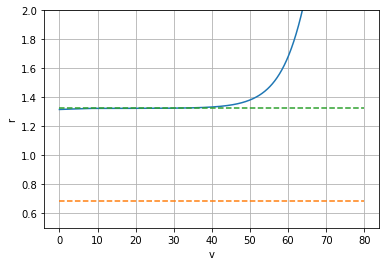

In [83]:
plt.plot(vrange,rnp[uval])
plt.plot([min(vrange),max(vrange)],[rminus,rminus],'--')
plt.plot([min(vrange),max(vrange)],[rplus,rplus],'--')
if Lambda>0.0:
    plt.plot([min(vrange),max(vrange)],[rcosm,rcosm],'--')
#plt.ylim(rcosm-.0000001,rcosm+.0000001)
#plt.ylim(rminus-.001,rminus+.001)
plt.xlabel('v')
plt.ylabel('r')
plt.ylim(0.5,2.0)
#plt.yscale('log')
plt.grid()
plt.show()

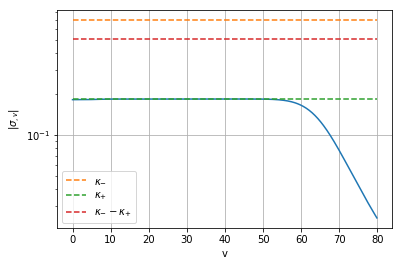

0.026093561794183248 0.6916694827996395


In [85]:
plt.plot(vrange2,np.abs(dsignpv[uval])/dercorr)
#plt.plot(vrange2,np.abs(dsignpu[uval])/dercorr)
plt.plot([min(vrange2),max(vrange2)],[kappaminus,kappaminus],'--',label=r'$\kappa_{-}$')
#plt.plot([min(vrange),max(vrange)],[kappaminus-kappacosm,kappaminus-kappacosm],'--',label=r'$\kappa_{-}-\kappa_{c}$')
#plt.plot([min(vrange),max(vrange)],[kappaminus-kappaplus,kappaminus-kappaplus],'--',label=r'$\kappa_{-}-\kappa_{+}$')
plt.plot([min(vrange2),max(vrange2)],[kappaplus,kappaplus],'--',label=r'$\kappa_{+}$')
if Lambda>0.0:
    plt.plot([min(vrange2),max(vrange2)],[kappacosm,kappacosm],'--',label=r'$\kappa_{c}$')
    plt.plot([min(vrange2),max(vrange2)],[kappaminus-2*kappacosm,kappaminus-2*kappacosm],'--',label=r'$\kappa_{-}-2\kappa_{c}$')
plt.plot([min(vrange2),max(vrange2)],[kappaminus-kappaplus,kappaminus-kappaplus],'--',label=r'$\kappa_{-}-\kappa_{+}$')
#plt.plot([min(vrange),max(vrange)],[kappaplus-kappacosm,kappaplus-kappacosm],'--',label=r'$\kappa_{c}$')
plt.yscale('log')
#plt.ylim(1,2)
#plt.ylim(.4,1)
plt.xlabel('v')
plt.ylabel(r'|$\sigma_{,v}$|')
plt.legend(loc='best')
plt.grid()
plt.show()

print(np.abs(dsignpv[uval][-5]),kappaminus)

1390 640
0.0 [0.02836622 3.83616869]
0.02473593477183429


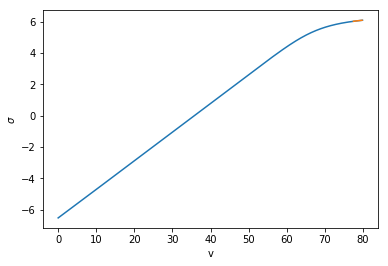

0.02830784494823573
0.0 0.0 0.6916694827996395 0.18323578765411241
0.0 0.6916694827996395
0.0 0.508433695145527


In [86]:

print(Nu,Nv)
v1=Nv-20
v2=Nv-1
print(0.0,np.polyfit(vrange2[v1:v2],signp[uval][v1:v2],1.0))
print(dsignpv[uval][v2])

plt.plot(vrange2,signp[uval])
plt.plot(vrange2[v1:v2],signp[uval][v1:v2])
plt.xlabel('v')
plt.ylabel(r'$\sigma$')
plt.show()

print(np.abs(dsignpv[uval][int((v1+v2)/2)]))
print(0.0,kappacosm,kappaminus,kappaplus)
print(0.0,kappaminus-kappacosm)
print(0.0,kappaminus-kappaplus)

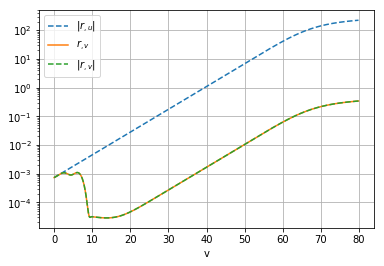

0 2.8769926617761665e-05


In [89]:
plt.plot(vrange2,np.abs(drnpu[uval])/dercorr,'--',label=r'$|r_{,u}|$')
plt.plot(vrange2,drnpv[uval]/dercorr,label=r'$r_{,v}$')
plt.plot(vrange2,np.abs(drnpv[uval])/dercorr,'--',label=r'$|r_{,v}|$')
#plt.plot(vrange2[0:Nv-1],np.abs(np.diff(rnp[uval])/np.diff(vrange2)))
plt.yscale('log')
plt.xlabel('v')
#plt.ylabel(r'|$\sigma_{,v}$|')
plt.legend(loc='best')
plt.grid()
plt.show()

print(0,nanmin(drnpv[uval]))

640
0.0 [ 0.02574658 -3.12941331]


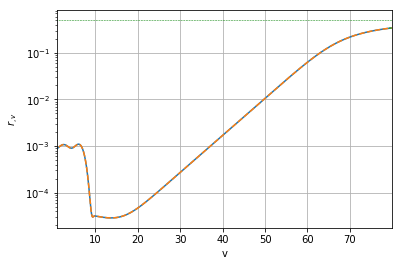

0.0 [-0.08146892  8.21496041]


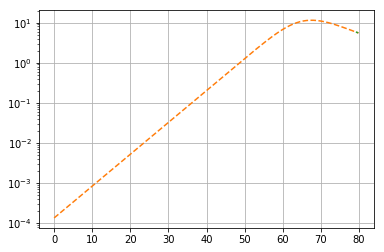

0.0 0.0 0.18323578765411241 0.6916694827996395
0.508433695145527
0.6916694827996395


In [90]:
v1=Nv-5
v2=Nv-2
print(Nv)
print(0.0,np.polyfit(vrange2[v1:v2],np.log(np.abs(drnpv[uval][v1:v2]/dercorr)),1.0))
plt.plot(vrange2,drnpv[uval])
plt.plot(vrange2,np.abs(drnpv[uval]/dercorr),'--')
#plt.plot(vrange2[0:Nv-1],np.abs(np.diff(rnp[uval])/np.diff(vrange2)),'-.')
plt.plot(vrange2[v1:v2],np.abs(drnpv[uval][v1:v2]/dercorr))
#plt.plot(vrange2[v1:v2-1],np.log(np.abs(np.diff(rnp[uval][v1:v2])/np.diff(vrange2[v1:v2]))),'-.')
#plt.xlim(30,100)
plt.plot([vrange2[0],vrange2[-1]],[.5,.5],'g--',linewidth=.5)
plt.yscale('log')
#plt.xscale('log')
plt.xlim(1,vrange2[-1])
plt.xlabel('v')
plt.ylabel(r'$r_{,v}$')
plt.grid()
#plt.savefig('num-rel-pics/drdv_vs_v_EH.png',dpi=300)
plt.show()


Rfunc=odeu.Rfunc(drnpv[uval],drnpu[uval],rnp[uval],signp[uval],Q,Lambda)
#Rfunc2=-drnpv[uval]*drnpu[uval]/rnp[uval]-np.exp(signp[uval])/(4.0*rnp[uval])*(1.0-np.power((Q/rnp[uval]),2.0)-Lambda*np.power(rnp[uval],2.0))
print(0.0,np.polyfit(vrange2[v1:v2],np.log(np.abs(Rfunc[v1:v2])),1.0))
#plt.plot(vrange2,Rfunc/dercorr)
plt.plot(vrange2,(Rfunc))
plt.plot(vrange2,np.abs(Rfunc),'--')
#plt.plot(vrange2,np.abs(Rfunc2),'--')
plt.plot(vrange2[v1:v2],np.abs(Rfunc[v1:v2]))
    #plt.plot(vrange2[0:Nv-1],np.abs(np.diff(rnp[uval])/np.diff(vrange2)))
#plt.yscale('log')
plt.grid()
#plt.xlim(200,300)
plt.yscale('log')
plt.show()

#print(0.0,np.polyfit(np.log(vrange2[v1:v2-1]),np.log(np.abs(np.diff(rnp[uval][v1:v2])/np.diff(vrange2[v1:v2]))),1.0))
print(0.0,kappacosm,kappaplus,kappaminus)
print(kappaminus-kappaplus)
print(kappaminus-kappacosm)

0.0 1390
0.006250000000000001
30.193749999977072
41.837734375012296
41.97479736340685
42.008009033328435
42.022416763108936
42.02986686670218
42.03493282270467
42.03865787450129
42.041257934162
42.0431004332433
42.04496295948854
42.046107158779826
42.04702840797729
42.04795967075298


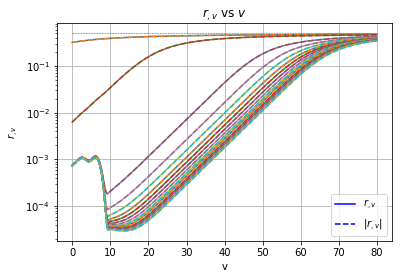

0.0 1390


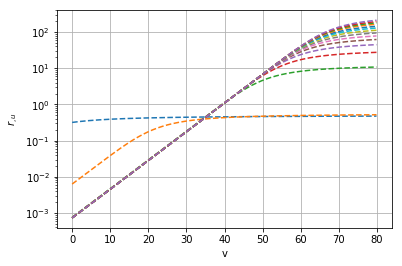

0.0 1390


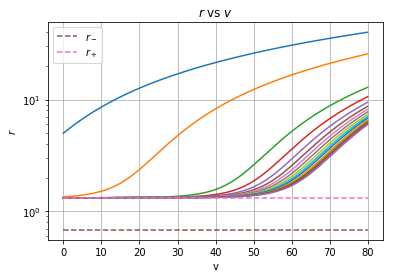

In [52]:
print(0.0,Nu)
numlines=15
ims=[]
for i in range(numlines):
    i=int(i*Nu/numlines)
    plt.plot(vrange2,(drnpv[i])/dercorr)
    plt.plot(vrange2,np.abs(drnpv[i])/dercorr,'--')
    print(urange[i])
    #ims=ims.append([plt.imshow(np.abs(drnpv[i]),animated=True)])
    #plt.plot(vrange2,drnpv[i]/dercorr)
#plt.plot(vrange2[0:Nv-1],np.abs(np.diff(rnp[uval])/np.diff(vrange2)),'-.')
plt.plot([np.nan],[np.nan],'b',label=r'$r_{,v}$')
plt.plot([np.nan],[np.nan],'b--',label=r'$|r_{,v}|$')
plt.plot([vrange2[0],vrange2[-1]],[.5,.5],'g--',linewidth=.5)
plt.xlabel('v')
plt.ylabel(r'$r_{,v}$')
plt.yscale('log')
#plt.xscale('log')
#plt.xlim(10,200)
plt.legend(loc='best')
plt.grid()
plt.title(r'$r_{,v}$ vs $v$')
#plt.savefig('num-rel-pics/drdv_vs_v-doubleu.png',dpi=300)
plt.show()

print(0.0,Nu)
#numlines=5
for i in range(numlines):
    i=int(i*Nu/numlines)
    #plt.plot(vrange2,drnpu[i]/dercorr)
    plt.plot(vrange2,np.abs(drnpu[i])/dercorr,'--')
    #plt.plot(vrange2[0:Nv-1],np.abs(np.diff(rnp[uval])/np.diff(vrange2)))
plt.yscale('log')
plt.xlabel('v')
plt.ylabel(r'$r_{,u}$')
#plt.xlim(0,6)
plt.grid()
#plt.savefig('num-rel-pics/Tol=.05_N=100_Nv=100.png',dpi=300)
#plt.savefig('num-rel-pics/drdu_vs_v.png',dpi=300)
plt.show()

print(0.0,Nu)
#numlines=5
ims=[]
for i in range(numlines):
    i=int(i*Nu/numlines)
    plt.plot(vrange2,(rnp[i])/dercorr)
    #plt.plot(vrange2,np.abs(rnp[i])/dercorr,'--')
    
plt.plot([min(vrange),max(vrange)],[rminus,rminus],'--',label=r'$r_-$')
plt.plot([min(vrange),max(vrange)],[rplus,rplus],'--',label=r'$r_+$')
plt.xlabel('v')
plt.ylabel(r'$r$')
plt.yscale('log')
#plt.xscale('log')
#plt.xlim(0,10)
plt.legend(loc='best')
plt.title(r'$r$ vs $v$')
plt.grid()
#plt.savefig('num-rel-pics/r_vs_v.png',dpi=300)
plt.show()

78.75 79.375
0.0 [-8.93065284 27.33827027]
0.0


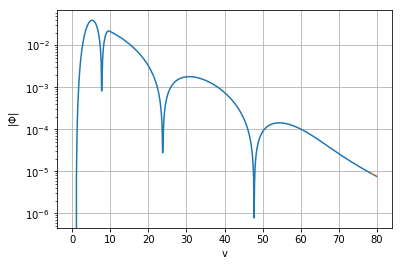

/home/brandon/.conda/envs/pycbc/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


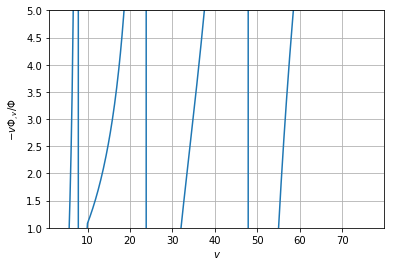

/home/brandon/.conda/envs/pycbc/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


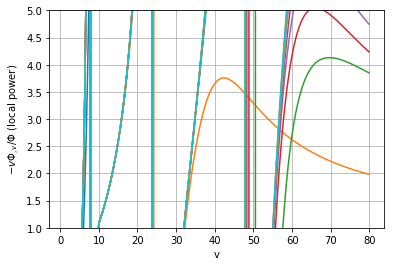

0.0 [2.87657607e-10 2.81231736e-03]


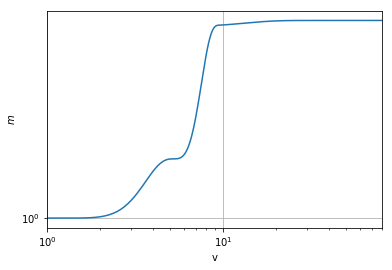

In [92]:
v1=Nv-10
v2=Nv-5
print(vrange2[v1],vrange2[v2])
print(0.0,np.polyfit(np.log(vrange2[v1:v2]),np.log(np.abs(phinp[uval][v1:v2])),1.0))
print(kappacosm)
plt.plot(vrange2,np.abs(phinp[uval])/dercorr)
plt.plot(vrange2[v1:v2],np.abs(phinp[uval][v1:v2])/dercorr)
#plt.xlim(1,vrange2[-1])
plt.yscale('log')
plt.ylabel(r'$|\Phi|$')
plt.xlabel('v')
#plt.xscale('log')
#plt.legend(loc='best')
plt.grid()
#plt.title('Phi along Event Horizon')
#plt.savefig('num-rel-pics/Phi vs v_bug_fixed.png',dpi=300)
plt.show()

plt.plot(vrange2,-vrange2*dphinpv[uval]/phinp[uval]/dercorr)
plt.plot(vrange2[v1:v2],-vrange2[v1:v2]*dphinpv[uval][v1:v2]/phinp[uval][v1:v2]/dercorr)
plt.ylim(1.0,5.0)
#plt.xscale('log')
plt.ylabel(r'$-v \Phi_{,v} /\Phi$')
plt.xlabel(r'$v$')
plt.xlim(1,vrange2[-1])
plt.grid()
#plt.savefig('num-rel-pics/Power of Phi vs v_bug_fixed.png',dpi=300)
plt.show()

numlines=10
for i in range(numlines):
    i=int(i*Nu/numlines)
    plt.plot(vrange2,-vrange2*dphinpv[i]/phinp[i]/dercorr)
    plt.ylim(1.0,5.0)
#plt.xscale('log')
plt.grid()
plt.ylabel(r'$-v \Phi_{,v} /\Phi$'+' (local power)')
plt.xlabel('v')
#plt.savefig('num-rel-pics/Powers of Phi vs v_bug_fixed.png',dpi=300)
plt.show()

print(0.0,np.polyfit(vrange2[v1:v2],np.log(np.abs(massnp[uval][v1:v2])),1.0))
plt.plot(vrange2,np.abs(massnp[uval])/dercorr)
plt.plot(vrange2[v1:v2],np.abs(massnp[uval][v1:v2])/dercorr)
plt.xlim(1,vrange[-1])
plt.yscale('log')
plt.xlabel('v')
plt.xscale('log')
#plt.legend(loc='best')
plt.xlabel('v')
plt.ylabel(r'$m$')
plt.grid()
#plt.savefig('num-rel-pics/Phi vs v_changed_method.png',dpi=300)
plt.show()

0.0 1390
0.006250000000000001
40.918046875044844
41.97479736340685
42.015539245562465
42.02986686670218
42.036815375763176
42.041257934162
42.044041709947884
42.046107158779826
42.04749904615425


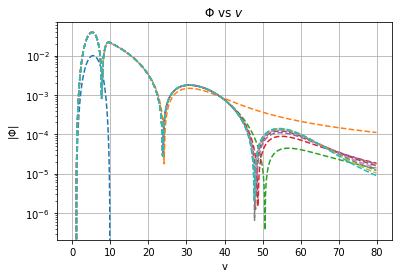

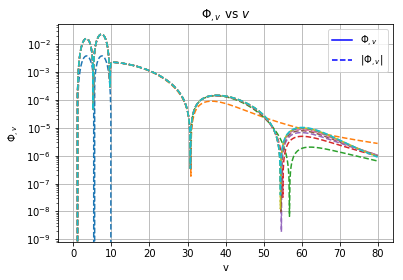

0.0 1390


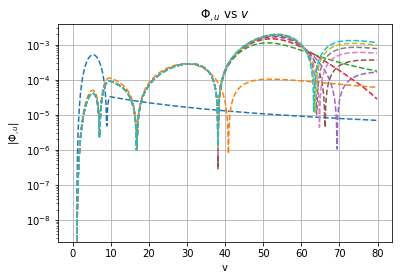

In [54]:
print(0.0,Nu)
numlines=10
for i in range(int(numlines*10/10)):
    i=int(i*Nu/numlines)
    
    plt.plot(vrange2,np.abs(phinp[i])/dercorr,'--')
    print(urange[i])
    #plt.plot(vrange2,drnpv[i]/dercorr)
#plt.plot(vrange2[0:Nv-1],np.abs(np.diff(rnp[uval])/np.diff(vrange2)),'-.')
#plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$|\Phi|$')
plt.xlabel('v')
#plt.xlim(.5,vrange2[-1])
plt.grid()
plt.title(r'$\Phi$ vs $v$')
#plt.savefig('num-rel-pics/Phis vs v-doulbeu.png',dpi=300)
plt.show()


#numlines=5
for i in range(numlines):
    i=int(i*Nu/numlines)
    #plt.plot(vrange2,dphinpv[i]/dercorr)
    plt.plot(vrange2,np.abs(dphinpv[i])/dercorr,'--')
    #plt.plot(vrange2,drnpv[i]/dercorr)
#plt.plot(vrange2[0:Nv-1],np.abs(np.diff(rnp[uval])/np.diff(vrange2)),'-.')
plt.plot([np.nan],[np.nan],'b',label=r'$\Phi_{,v}$')
plt.plot([np.nan],[np.nan],'b--',label=r'$|\Phi_{,v}|$')
plt.yscale('log')
plt.ylabel(r'$\Phi_{,v}$')
plt.xlabel('v')
#plt.xlim(0,10)
plt.title(r'$\Phi_{,v}$ vs $v$')
plt.grid()
plt.legend()
#plt.savefig('num-rel-pics/dPhidv vs v.png',dpi=300)
#plt.savefig('num-rel-pics/drdv_Mf='+str(M)+'_Q='+str(Q)+'_Lambda='+str(Lambda)+'_edd.png',dpi=300)
plt.show()

print(0.0,Nu)
#numlines=5
for i in range(numlines):
    i=int(i*Nu/numlines)
    #plt.plot(vrange2,drnpu[i]/dercorr)
    plt.plot(vrange2,np.abs(dphinpu[i])/dercorr,'--')
    #plt.plot(vrange2[0:Nv-1],np.abs(np.diff(rnp[uval])/np.diff(vrange2)))
plt.yscale('log')
plt.ylabel(r'$|\Phi_{,u}|$')
plt.xlabel('v')
#plt.xlim(0,6)
plt.title(r'$\Phi_{,u}$ vs $v$')
plt.grid()
#plt.savefig('num-rel-pics/Tol=.05_N=100_Nv=100.png',dpi=300)
#plt.savefig('num-rel-pics/drdu_Mf='+str(M)+'_Q='+str(Q)+'_Lambda='+str(Lambda)+'_edd.png',dpi=300)
plt.show()

0.0 [-0.13406259 -3.27271441]


/home/brandon/.conda/envs/pycbc/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


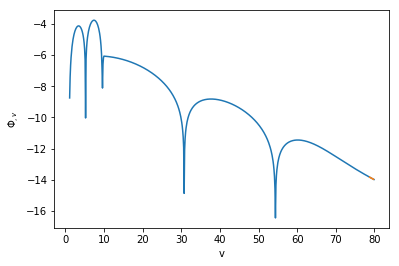

0.0 0.0


In [93]:
v1=Nv-10
v2=Nv-1
print(0.0,np.polyfit(vrange2[v1:v2],np.log(np.abs(dphinpv[uval][v1:v2]/dercorr)),1.0))
plt.plot(vrange2,np.log(np.abs(dphinpv[uval])))
plt.plot(vrange2[v1:v2],np.log(np.abs(dphinpv[uval][v1:v2])))
plt.xlabel('v')
plt.ylabel(r'$\Phi_{,v}$')
plt.show()
print(0.0,kappacosm)


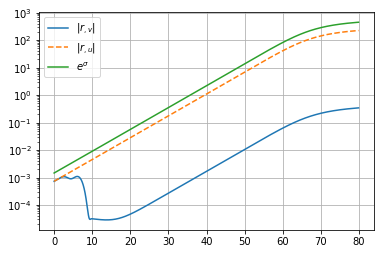

0 640 0.6916694827996395
0.0 [3.13521014e-07 2.80106975e-03]


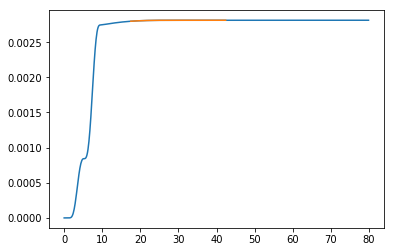

0.6916694827996395
0.6916694827996395


In [98]:
#plt.plot(vrange2,np.abs(massnp[uval]))
plt.plot(vrange2,np.abs(drnpv[uval]),label=r'$|r_{,v}|$')
plt.plot(vrange2,np.abs(drnpu[uval]),'--',label=r'$|r_{,u}|$')
plt.plot(vrange2,np.abs(np.exp(signp[uval])),label=r'$e^{\sigma}$')
#plt.ylim(massnp[uval,-1]-.00000000001,massnp[uval,-1]+.00000000001)
#plt.xscale('log')
plt.yscale('log')
#plt.xlim(100,300)
plt.legend(loc='best')
plt.grid()
plt.show()

print(0,Nv,kappaminus)
v1=Nv-500
v2=Nv-300
uval2=uval
print(0.0,np.polyfit(vrange2[v1:v2],np.log(np.abs(massnp[uval2][v1:v2])),1.0))
plt.plot(vrange2,np.log(np.abs(massnp[uval2])))
plt.plot(vrange2[v1:v2],np.log(np.abs(massnp[uval2][v1:v2])))
plt.show()

print(kappaminus)
print(kappaminus-2*kappacosm)

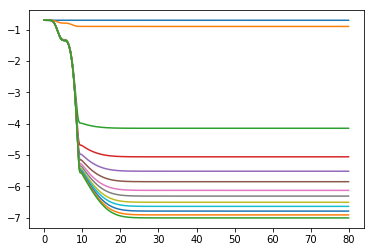

In [57]:
for i in range(int(Nu/100)):
    i2=100*i
    plt.plot(vrange,np.log(np.abs(np.exp(-signp[i2])*drnpv[i2])))#*drnpv[i2])))
plt.show()


640
[-0.17125604 -4.07453074]


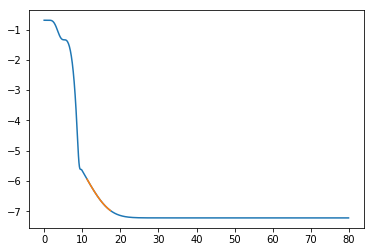

0.6916694827996395 0.6916694827996395 0.32519790749141464


In [58]:
print(Nv)
uval2=Nu-1
v1=Nv-550
v2=Nv-500
print(np.polyfit(vrange2[v1:v2],np.log(np.abs(np.exp(-signp[uval2][v1:v2])*drnpv[uval2][v1:v2])),1.0))
plt.plot(vrange2,np.log(np.abs(np.exp(-signp[uval2])*drnpv[uval2])))
plt.plot(vrange2[v1:v2],np.log(np.abs(np.exp(-signp[uval2][v1:v2])*drnpv[uval2][v1:v2])))
plt.show()

print(kappaminus,kappaminus-2*kappacosm,kappaminus-2*kappaplus)

In [59]:
print(massnp[0,-1])

1.0028514299104625


In [63]:
Rfunc=-drnpv[uval]*drnpu[uval]/rnp[uval]-np.exp(signp[uval])/(4.0*rnp[uval])*(1.0-np.power((Q/rnp[uval]),2.0)-Lambda*np.power(rnp[uval],2.0))

0.0 1390
0.006250000000000001
18.053124999988114
36.4281249999714
41.721777343796056
41.923789062578095
41.97479736340685
41.99749389663111
42.01105316167836
42.01986511216499
42.025380782818075
42.02986686670218
42.0334508128501
42.03569385479215
42.03789684241381
42.04013641298207
42.041257934162
42.042359428177996
42.04348094935792
42.04458244337392
42.04554639839876
42.046107158779826
42.046657905582656
42.04721866596372
42.04776941276655
42.04833017314761


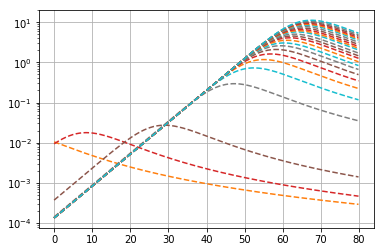

In [64]:
print(0.0,Nu)
numlines=25
for i in range(numlines):
    i=int(i*Nu/numlines)
    print(urange[i])
    Rfunc=-drnpv[i]*drnpu[i]/rnp[i]-np.exp(signp[i])/(4.0*rnp[i])*(1.0-np.power((Q/rnp[i]),2.0)-Lambda*np.power(rnp[i],2.0))
    #plt.plot(vrange2,Rfunc/dercorr)
    plt.plot(vrange2,(Rfunc))
    plt.plot(vrange2,np.abs(Rfunc),'--')
    #plt.plot(vrange2[0:Nv-1],np.abs(np.diff(rnp[uval])/np.diff(vrange2)))
plt.yscale('log')
plt.grid()
plt.show()
#plt.plot(vrange2,Rfunc)
#plt.plot(vrange2,np.abs(Rfunc),'--')
#plt.yscale('log')
#plt.show


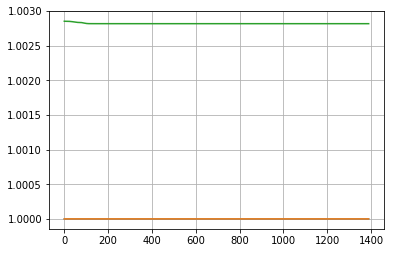

[[1.         1.         1.         ... 1.00285143 1.00285143 1.00285143]
 [1.         1.         1.         ... 1.0028514  1.0028514  1.0028514 ]
 [1.         1.         1.         ... 1.00285137 1.00285137 1.00285137]
 ...
 [1.         1.         1.         ... 1.0028163  1.0028163  1.0028163 ]
 [1.         1.         1.         ... 1.0028163  1.0028163  1.0028163 ]
 [1.         1.         1.         ... 1.0028163  1.0028163  1.0028163 ]]


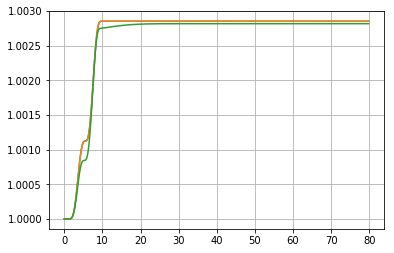

In [67]:
#plt.plot(urange,massnp[:,0])
#plt.plot(urange,massnp[:,1])
#plt.plot(urange,massnp[:,-1])
plt.plot(massnp[:,0])
plt.plot(massnp[:,1])
plt.plot(massnp[:,-1])
#plt.yscale('log')
plt.grid()
plt.show()
print(massnp)

plt.plot(vrange2,massnp[0])
plt.plot(vrange2,massnp[1])
plt.plot(vrange2,massnp[-1])
#plt.yscale('log')
plt.grid()
plt.show()

In [99]:
print(len(rnp),len(drnpv),len(drnpu),len(dphinpv),len(dphinpu),len(massnp))
rnpf=np.delete(rnp,-1,axis=0)
massnpf=np.delete(massnp,-1,axis=0)
print(len(rnpf),len(drnpv),len(drnpu),len(dphinpv),len(dphinpu),len(massnpf))
Curvature=odeu.Kretsch(rnp,drnpv,drnpu,dphinpv,dphinpu,massnp,Q,Lambda)


1390 1390 1390 1390 1390 1390
1389 1390 1390 1390 1390 1389


0.0 1251


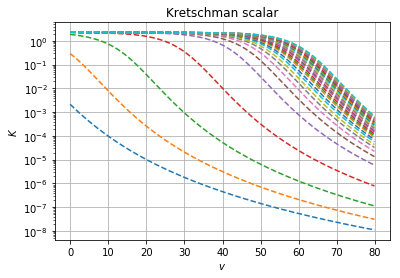

In [100]:
#plt.plot(vrange2,Curvature[30])
#plt.show()
Nuf=int(Nu*9/10)

print(0.0,Nuf)
numlines=30
for i in range(numlines):
    i=int(i*Nuf/numlines)
   
    plt.plot(vrange2,Curvature[i],'--')
plt.xlabel(r'$v$')
plt.ylabel(r'$K$')
plt.yscale('log')
plt.grid()
plt.title('Kretschman scalar')
#plt.savefig('num-rel-pics/K vs v.png',dpi=300)
plt.show()

print(rminus)
odeu.Kretsch(rminus,1,1,0,0,M0,Q,Lambda)

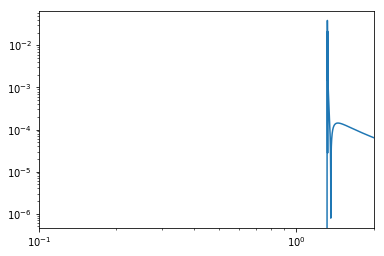

In [71]:
plt.plot(rnp[uval],np.abs(phinp[uval]))
#plt.ylim(0,.0001)
#plt.xlim(min(rnp[uval])+.1,1)
plt.yscale('log')
plt.xlim(.1,2)
plt.xscale('log')
plt.show()

In [72]:
print(drnpu)
print(drnpv)

[[-3.18050000e-01 -3.19346676e-01 -3.20630357e-01 ... -4.75738843e-01
  -4.75775239e-01 -4.75811532e-01]
 [-3.14583620e-01 -3.15914910e-01 -3.17232931e-01 ... -4.75655265e-01
  -4.75691938e-01 -4.75728505e-01]
 [-3.11025103e-01 -3.12391707e-01 -3.13744779e-01 ... -4.75571468e-01
  -4.75608420e-01 -4.75645265e-01]
 ...
 [-7.31886511e-04 -7.48675152e-04 -7.65849128e-04 ... -2.30376676e+02
  -2.31124048e+02 -2.31863848e+02]
 [-7.31885182e-04 -7.48673792e-04 -7.65847736e-04 ... -2.30623837e+02
  -2.31372561e+02 -2.32113700e+02]
 [-7.31883852e-04 -7.48672431e-04 -7.65846345e-04 ... -2.30871543e+02
  -2.31621624e+02 -2.32364105e+02]]
[[0.31805    0.31934668 0.32063036 ... 0.47520596 0.47524231 0.47527856]
 [0.31458362 0.31591491 0.31723293 ... 0.47510992 0.47514655 0.47518307]
 [0.3110251  0.31239171 0.31374478 ... 0.47501315 0.47505005 0.47508686]
 ...
 [0.00073189 0.00074868 0.00076585 ... 0.33766188 0.3387573  0.33984162]
 [0.00073189 0.00074867 0.00076585 ... 0.33760165 0.33869768 0.3397

### This last section is meant for Eddington Coordinates (u and v) only

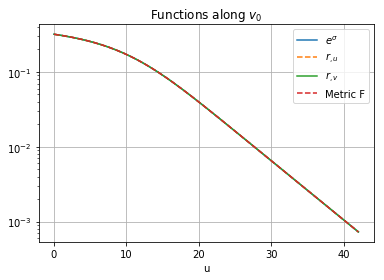

In [73]:
metricf=0.5*np.abs(1-2*massnp/rnp+Q**2.0/rnp**2.0-Lambda*rnp**2.0/3)

plt.plot(urange,0.5*np.exp(signp[:,0]),label=r'$e^{\sigma}$')
plt.plot(urange,np.abs(drnpu[:,0]),'--',label=r'$r_{,u}$')
plt.plot(urange,np.abs(drnpv[:,0]),label=r'$r_{,v}$')
plt.plot(urange,metricf[:,0],'--',label=r'Metric F')
#plt.plot(urange,np.abs(dsignpu[:,0]),label=r'$r_{,v}$')
#plt.xlim(99,100)
plt.yscale('log')
plt.xlabel('u')
plt.grid()
plt.legend(loc='best')
plt.title(r'Functions along $v_{0}$')
#plt.savefig('num-rel-pics/esig_drdu_drdv_vs_u_v0.png',dpi=300)
plt.show()


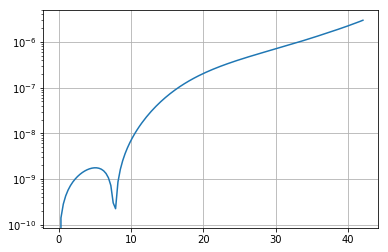

2.993775541777181e-08


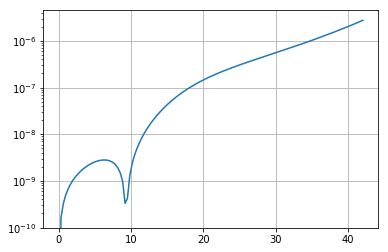

2.762716296866426e-08


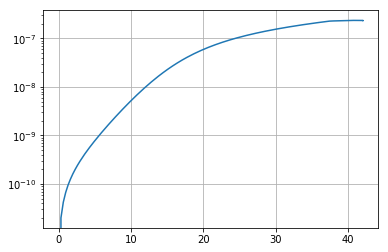

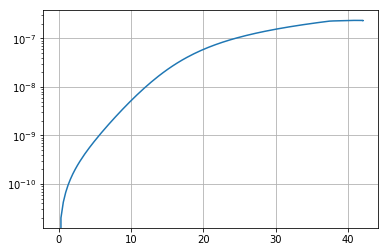

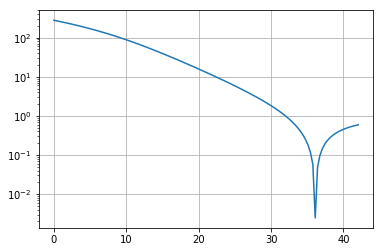

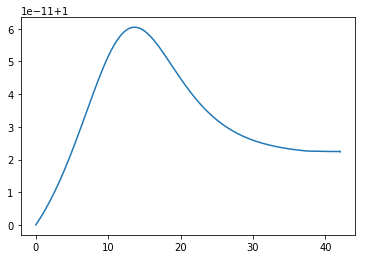

1.0 1.0000000000010922 1.0000000000022413
1.3162848914595648
1.3241038293801468


In [74]:
plt.plot(urange,np.abs(0.5*np.exp(signp[:,0])-np.abs(drnpv[:,0]))/(0.5*np.exp(signp[:,0]))*100)
plt.yscale('log')
plt.grid()
plt.show()

print((np.abs(0.5*np.exp(signp[:,0])-np.abs(drnpv[:,0]))/(0.5*np.exp(signp[:,0])))[-1])

plt.plot(urange,np.abs(metricf[:,0]-0.5*np.exp(signp[:,0]))/(metricf[:,0])*100)
plt.yscale('log')
plt.grid()
plt.show()

print((np.abs(metricf[:,0]-0.5*np.exp(signp[:,0]))/(metricf[:,0]))[-1])

plt.plot(urange,np.abs(metricf[:,0]-np.abs(drnpv[:,0]))/(metricf[:,0])*100)
plt.yscale('log')
plt.grid()
plt.show()


plt.plot(urange,np.abs(0.5*np.exp(signp[:,0])-np.abs(drnpu[:,0]))/(0.5*np.exp(signp[:,0]))*100)
plt.yscale('log')
plt.grid()
plt.show()

plt.plot(urange,np.abs(rnp[:,0]-rplus)/(rplus)*100)
plt.yscale('log')
plt.grid()
plt.show()

plt.plot(urange,massnp[:,0])
plt.show()
print(massnp[0,0],massnp[1,0],massnp[2,0])

#print(rnp[:,0])
print(rnp[-1,0])
print(rplus)

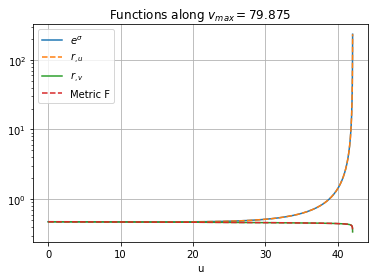

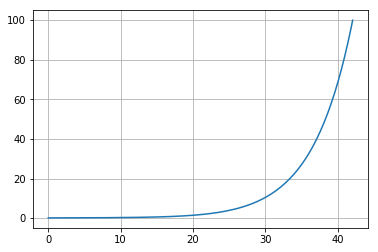

In [75]:
plt.plot(urange,0.5*np.exp(signp[:,-1]),label=r'$e^{\sigma}$')
plt.plot(urange,np.abs(drnpu[:,-1]),'--',label=r'$r_{,u}$')
plt.plot(urange,np.abs(drnpv[:,-1]),label=r'$r_{,v}$')
plt.plot(urange,0.5*np.abs(1-2*massnp[:,-1]/rnp[:,-1]+Q**2.0/rnp[:,-1]**2.0-Lambda*rnp[:,-1]**2.0/3),'--',label=r'Metric F')
#plt.plot(urange,np.abs(dsignpu[:,-1]),label=r'$r_{,v}$')
plt.yscale('log')
plt.yscale('log')
plt.xlabel('u')
plt.grid()
plt.legend(loc='best')
plt.title(r'Functions along $v_{max}=$'+str(vrange[-1]))
#plt.xlim(37.9396621,37.9396623)
#plt.savefig('num-rel-pics/esig_drdu_drdv_vs_u_vmax.png',dpi=300)
plt.show()

plt.plot(urange,np.abs(np.abs(drnpu[:,-1])-np.abs(drnpv[:,-1]))/(np.abs(drnpu[:,-1]))*100)
#plt.yscale('log')
plt.grid()
plt.show()

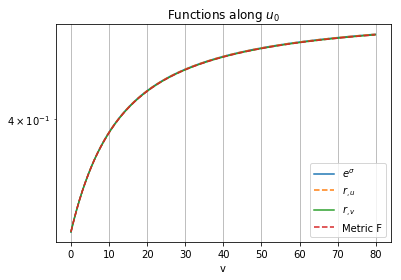

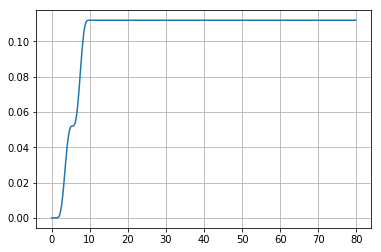

In [76]:
plt.plot(vrange,0.5*np.exp(signp[0]),label=r'$e^{\sigma}$')
plt.plot(vrange,np.abs(drnpu[0]),'--',label=r'$r_{,u}$')
plt.plot(vrange,np.abs(drnpv[0]),label=r'$r_{,v}$')
plt.plot(vrange,0.5*np.abs(1-2*massnp[0]/rnp[0]+Q**2.0/rnp[0]**2.0-Lambda*rnp[0]**2.0/3),'--',label=r'Metric F')
#plt.xlim(0,10)
plt.yscale('log')
plt.xlabel('v')
plt.grid()
plt.legend(loc='best')
plt.title(r'Functions along $u_{0}$')
#plt.savefig('num-rel-pics/esig_drdu_drdv_vs_u_u0.png',dpi=300)
plt.show()

plt.plot(vrange,np.abs(np.abs(drnpu[0])-np.abs(drnpv[0]))/(np.abs(drnpu[0]))*100)
#plt.yscale('log')
plt.grid()
plt.show()


0.0 1390 640


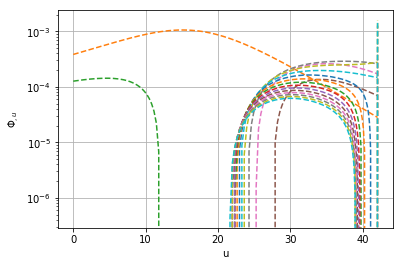

In [77]:
print(0.0,Nu,Nv)
numlines=20
for i in range(numlines):
    i=int(i*Nv/numlines)
    #plt.plot(vrange2,drnpu[i]/dercorr)
    plt.plot(urange,dphinpu[:,i],'--')
    #plt.plot(vrange2[0:Nv-1],np.abs(np.diff(rnp[uval])/np.diff(vrange2)))
plt.yscale('log')
plt.xlabel('u')
plt.ylabel(r'$\Phi_{,u}$')
#plt.xlim(0,6)
plt.grid()
#plt.savefig('num-rel-pics/Tol=.05_N=100_Nv=100.png',dpi=300)
#plt.savefig('num-rel-pics/dphidu_vs_u.png',dpi=300)
plt.show()

640
0.0 [  133.81655854 -5633.43918214]


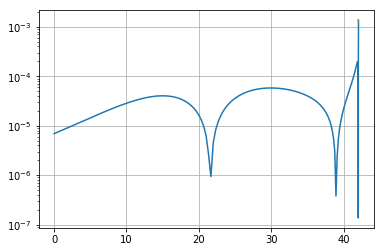

0.0 0.18323578765411241 0.6916694827996395



In [78]:
print(Nv)
vval=Nv-1
u1=Nu-10
u2=Nu-5
print(0.0,np.polyfit(urange[u1:u2],np.log(np.abs(dphinpu[u1:u2,vval])),1.0))
plt.plot(urange,np.abs(dphinpu[:,vval]))
plt.plot(urange[u1:u2],np.abs(dphinpu[u1:u2,vval]))
plt.yscale('log')
#plt.xscale('log')
plt.grid()
plt.show()
print(kappacosm,kappaplus,kappaminus)
print()



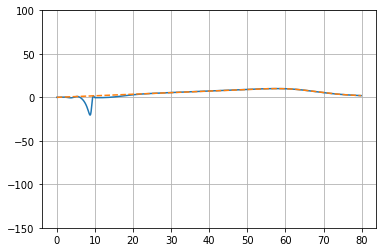

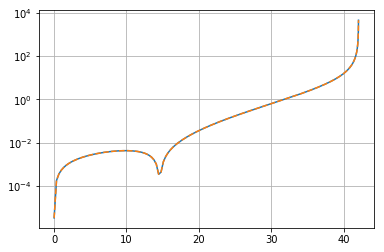

In [79]:
drnpvv=dsignpv[uval]*drnpv[uval]-rnp[uval]*(dphinpv[uval])**2.0
plt.plot(vrange2,vrange2*drnpvv/drnpv[uval])
plt.plot(vrange2,vrange2*dsignpv[uval],'--')
#-vrange2*dphinpv[i]/phinp[i]
#plt.plot(vrange2,-vrange2*drnpv[i]/rnp[i])
plt.grid()
#plt.yscale('log')
plt.ylim(-150,100)
plt.show()

drnpuu=dsignpu[:,vval]*drnpu[:,vval]-rnp[:,vval]*(dphinpu[:,vval])**2.0
plt.plot(urange,np.abs(urange*drnpuu/drnpu[:,vval]))
plt.plot(urange,np.abs(urange*dsignpu[:,vval]),'--')
#-vrange2*dphinpv[i]/phinp[i]
#plt.plot(vrange2,-vrange2*drnpv[i]/rnp[i])
plt.grid()
plt.yscale('log')
#plt.ylim(10**2,10**7)
plt.show()

No handles with labels found to put in legend.


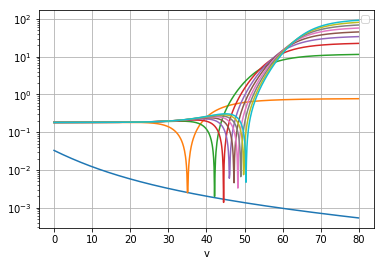

In [42]:
numlines=10
ims=[]
for i in range(numlines):
    i=int(i*Nu/numlines)
    plt.plot(vrange2,np.abs(dsignpu[i])/dercorr)
    #plt.plot(vrange2,np.abs(rnp[i])/dercorr,'--')
    
#plt.plot([min(vrange),max(vrange)],[rminus,rminus],'--',label=r'$r_-$')
#plt.plot([min(vrange),max(vrange)],[rplus,rplus],'--',label=r'$r_+$')
plt.xlabel('v')
#plt.ylabel(r'$r$')
plt.yscale('log')
#plt.xscale('log')
#plt.xlim(0,10)
plt.legend(loc='best')
#plt.title(r'$r$ vs $v$')
plt.grid()
#plt.savefig('num-rel-pics/r_vs_v.png',dpi=300)
plt.show()

In [43]:
1/(rnp[uval])*dv0*-.5*odeu.trapint(drnpu[uval]*dphinpv[uval])

array([-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  1.21470067e-16,  7.14121903e-16,  2.21189299e-15,
        5.00304647e-15,  9.42908884e-15,  1.57838596e-14,  2.43128053e-14,
        3.52124502e-14,  4.86300750e-14,  6.46636138e-14,  8.33617796e-14,
        1.04724425e-13,  1.28703145e-13,  1.55202132e-13,  1.84079280e-13,
        2.15147552e-13,  2.48176604e-13,  2.82894687e-13,  3.18990815e-13,
        3.56117207e-13,  3.93892025e-13,  4.31902383e-13,  4.69707662e-13,
        5.06843113e-13,  5.42823753e-13,  5.77148563e-13,  6.09304972e-13,
        6.38773624e-13,  6.65033418e-13,  6.87566796e-13,  7.05865267e-13,
        7.19435137e-13,  7.27803403e-13,  7.30523796e-13,  7.27182896e-13,
        7.17406313e-13,  7.00864853e-13,  6.77280620e-13,  6.46433008e-13,
        6.08164512e-13,  5.62386285e-13,  5.09083396e-13,  4.48319683e-13,
        3.80242154e-13,  

5000
dr/dv is -0.31805
Using Full Eddington Coordinates
[-0.31805    -0.31805    -0.31805    ... -0.31804977 -0.31804977
 -0.31804977]
[0.31805    0.31805    0.31805    ... 0.31804977 0.31804977 0.31804977]


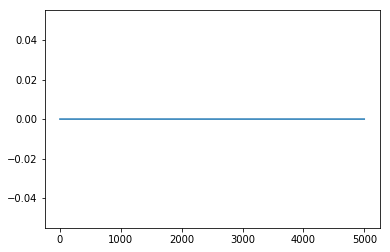

In [44]:
N=10
umax2=500
Nu2=int(umax2*N)
print(Nu2)
boundary=odeu.boundaryv(1,'edd','edd',Nu2,ru0,-dr0v,dv0,vmax,M0,Q,Lambda,False,0,10,float)
print(boundary[3])
print(boundary[6])

plt.plot(np.abs(np.abs(boundary[3])-np.abs(boundary[6]))/boundary[6]*100)
plt.show()